# Problem formulation


The machine learning problem I want to solve is predicting participants ID (S1, S2, etc.), given their humming audio file. This is a classification problem which uses the characteristics from their voice to identify their ID. This is very interesting, as if we have enough labelled audio recordings with someones humming, we may be able to predict who they are. This could have many uses, for example in crime suspect investigation. It also has implications for personal privacy. 

# Machine Learning pipeline


Input and Output:
The input to the pipeline is hum audio files (and their filenames) from the hum and whistles dataset, and the output is a prediction on whether the inputted audio file belongs to a given participant. The machine learning model outputs the ID of the participant. Only 25 participants are used for this model.

Preprocessing:
After the file names are inputted, a dataframe is built storing the file ID, interpretation (hum), number (e.g. hum_1 or hum_2), and song. The file names are used as an index for this dataframe. No whistle data will be used for solving this problem. Some preprocessing steps are used to create the dataframe. For example, sample "S55" was removed due to the file name adding complexity to the string processing used to construct the dataframe. Also, file names which contained spaces and led to Index Errors were also removed.

Feature Extraction:
Feature extraction then took place, to extract ten features from the audio files: power, pitch_mean, pitch_std, voiced_fr, tempo, mean, standard_dev, inter_quartile_range, spectral_centroid, spectral_rolloff. All of these features provide important information on audio files, thus can be very valuable to train the model with.

Feature Selection:
The most important features were selected in this stage (based on scores of various models, and confusion matrices). The most important features which ended up being selected were: power, pitch_mean, pitch_std, voiced_fr, spectral_centroid, spectral_rolloff.

Transformations & Modelling:
A machine learning algorithm was trained in this stage, which took the normalised selected features as input to make predictions. Normalisation of the data was achieved through using StandardScaler.

# Transformation stage


Feature Extraction:
Feature extraction was implemented using a similar approach to the Starter Kit  template. A getXy function was created, which took files and a labels file (dataframe) as input. Various methods from the librosa library were used to extract features from the dataset. The features which were extracted are stated in section 3. The output of the getXy function was an X numpy array containing 8 predictors for each sample, and a label array y, which contained the label of the participant.

Normalisation:
The data was normalised before being inputted to the model. This was achieved through using sklearn's StandardScaler, which uses a z-score normalisation method. However, data leakage is a very common problem in this stage if you use cross-validation to score the model. This is because the cross-validation splits the data 4:1, and repeats this process with different folds (5 fold cross-validation). If we normalise all of the training data and perform cross validation, the StandardScaler will also fit the validation set resulting in a data leakage. To overcome this problem, a pipeline was created containing the scaler and the model. This was inputted into the GridSearchCV to cross-validate with the training data being scaled only.

# Modelling

SVM: SVM's transform inputted data and finds boundaries that find the largest separation between two classes. SVM's usually support binary classification, and this machine learning problem has 25 classes. Therefore a one-vs-rest SVM approach must be used. This separates points belonging to different classes rather than just one.

ExtraTreesClassifier: ExtraTreeClassifiers are similar to RandomTreeClassifiers, however it is less "greedy" as it uses a random value for the split for the extra tree. ExtraTreeClassifiers can perform better than RandomTreeClassifiers on noisy datasets.




# Methodology

Models are trained using a nested cross-validation approach. This accomplishes both hyperparameter tuning, and model selection. Firstly, the data is split into a training and test set. The test set is left untouched for now. Secondly,  a pipeline is built, containing a scaler, and classifier (to ensure no data leakage in scaling). GridSearchCV is then used in an "inner cross-validation loop" for the hyperparameter tuning, this is computed for each iteration of the "outer cross-validation loop". The average accuracy over the different test folds are then printed and used as a score. The best model is chosen with regards to the score it achieves on the outer loop. 

This score is compared for the two algorithms (SVM, ExtraTreesClassifier), and the one with the higher score is chosen to be the final model to predict the test data with. Training scores are also taken into consideration so we can see if the models are overfitting.

The final model is then fit with the entirety of the X_train, y_train data so that it has more samples to learn from. The final training accuracy is obtained here. This model is then used to score X_test and y_test, and come up with a final test accuracy of the model, and a classification report.

Accuracy is a good metric to use, as the classes are balanced.

# Dataset

Describe the dataset that you will use to create your models and validate them. If you need to preprocess it, do it here. Include visualisations too. You can visualise raw data samples or extracted features.

The dataset used to build the models are obtained from inputted audio files. After the preprocessing, oddly named files, and whistle files are removed. Then the following features are extracted in the getXy method, using the librosa library: power, pitch_mean, pitch_std, voiced_fr, tempo, mean, standard_dev, inter_quartile_range, spectral_centroid, spectral_rolloff. Spectral centroid is an especially useful feature to have, as it measures the timbre in audio, which can help identify different samples. Tempo is not a very good feature to identify individuals as tempo tends to change for different songs. 

After the features are extracted, some of the hum files are removed. Better models can be produced if we only try to predict participants that have contributed a substantial amount of samples to the Hums and Whistles dataset. As the maximum number of files that a participant can have is 16, only features for these participants are kept. 

As the number of participants left in the dataset is 80+, a subset of this dataset containing 25 participants is used to train/validate/test the model. As a result there are 16 (files) * 25 (participants) = 400 samples


In [ ]:
from google.colab import drive
from google.colab import files

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os, sys, re, pickle, glob
import urllib.request
import zipfile

import IPython.display as ipd
from tqdm import tqdm
import librosa

drive.mount('/content/drive')

Mounted at /content/drive


Import files...

In [ ]:
hp_sw_original = hp1 + hp2 + sw1 + sw2 + p1 + p2 + r1 + r2 + hak1 + hak2 + mam1 + mam2 + sh1 + sh2 + fr1 + fr2


# for file in hp_sw_original:
#   print(file.split("/")[8])

In [ ]:
# Remove the "S55" sample.

hp_sw = []

for l in hp_sw_original:
  if "S55" not in l:
    hp_sw.append(l)

In [ ]:
# Code to remove the whistles samples

whistles = []

for s in hp_sw:
  interpretation_type = s.split('/')[-1].split('_')[1]
  if interpretation_type[0] == "w" or interpretation_type[0] == "W":
    whistles.append(s)

hp_sw = [x for x in hp_sw if x not in whistles] 

In [ ]:
# Table with information about the audio files.
# Files which cause an IndexError (mostly files with spaces) are not included.

hw_table = []
index_error_files = []  # all the files which result in index error

for file in hp_sw:
  try:
    file_name = file.split('/')[-1]
    participant_ID = file.split('/')[-1].split('_')[0]
    interpretation_type = file.split('/')[-1].split('_')[1]
    interpretation_number = file.split('/')[-1].split('_')[2]
    song = file.split('/')[-1].split('_')[3].split('.')[0]
    hw_table.append([file_name,participant_ID,interpretation_type,interpretation_number, song])
  except IndexError:
    index_error_files.append(file) # Append the file that caused index error
    continue

# hw_table

In [ ]:
hp_sw = [x for x in hp_sw if x not in index_error_files] # remove the files that cause index error

In [ ]:
len(hw_table)

2333

In [ ]:
hw_df = pd.DataFrame(hw_table,columns=['file_id','participant','interpretation','number','song']).set_index('file_id') 
hw_df

,participant,interpretation,number,song
file_id,,,,
S1_hum_2_Potter.wav,S1,hum,2,Potter
S3_hum_2_Potter.wav,S3,hum,2,Potter
S3_hum_1_Potter.wav,S3,hum,1,Potter
S2_hum_2_Potter.wav,S2,hum,2,Potter
S4_hum_1_Potter.wav,S4,hum,1,Potter
...,...,...,...,...
S219_hum_2_Frozen.wav,S219,hum,2,Frozen
S219_hum_4_Frozen.wav,S219,hum,4,Frozen
S221_hum_1_Frozen.wav,S221,hum,1,Frozen


In [ ]:
print("Interpretations:")
print(hw_df["interpretation"].value_counts())
print()
print("Song labels:")
print(hw_df["song"].value_counts())

Interpretations:
hum     2246
Hum       83
hum2       2
Hun        1
ham        1
Name: interpretation, dtype: int64

Song labels:
Hakuna          250
Frozen          249
Panther         247
Rain            244
Mamma           242
               ... 
[Mamma]           1
pinkpanther       1
[  Panther ]      1
[Hukuna]          1
imperial          1
Name: song, Length: 90, dtype: int64


In [ ]:
# Make sure all the interpretations are uniform. "hum" for hums

interpretations = hw_df["interpretation"]
new_inter = []

for s in interpretations:
    new_inter.append("hum")

hw_df["interpretation"] = pd.Series(new_inter).values

hw_df["interpretation"].value_counts()

hum    2333
Name: interpretation, dtype: int64

In [ ]:
def getPitch(x,fs,winLen=0.02):
  #winLen = 0.02 
  p = winLen*fs
  frame_length = int(2**int(p-1).bit_length())
  hop_length = frame_length//2
  f0, voiced_flag, voiced_probs = librosa.pyin(y=x, fmin=80, fmax=450, sr=fs,
                                                 frame_length=frame_length,hop_length=hop_length)
  return f0,voiced_flag

In [ ]:
import scipy.stats

def getXy(files,labels_file, scale_audio=False, onlySingleDigit=False):
  X,y =[],[]
  for file in tqdm(files):
    fileID = file.split('/')[-1]
    file_name = file.split('/')[-1]
    yi = labels_file.loc[fileID]['participant']

    fs = None # if None, fs would be 22050
    x, fs = librosa.load(file,sr=fs)
    if scale_audio: x = x/np.max(np.abs(x))
    f0, voiced_flag = getPitch(x,fs,winLen=0.02)
      
    freqs = np.fft.fftfreq(x.size)

    # calculate features for feature extraction      
    power = np.sum(x**2)/len(x)
    pitch_mean = np.nanmean(f0) if np.mean(np.isnan(f0))<1 else 0
    pitch_std  = np.nanstd(f0) if np.mean(np.isnan(f0))<1 else 0
    voiced_fr = np.mean(voiced_flag)
    tempo = librosa.beat.tempo(x)[0] 
    mean = np.mean(freqs) 
    standard_dev = np.std(freqs) 
    inter_quartile_range = scipy.stats.iqr(freqs) 
    spectral_centroid = librosa.feature.spectral_centroid(x, sr=fs)[0].mean()
    spectral_rolloff = librosa.feature.spectral_rolloff(x+0.01, sr=fs)[0].mean()

    # xi = []
    # mfcc = librosa.feature.mfcc(x, n_mfcc=13, sr=fs)
    # for c in mfcc:
    #   xi.append(c.mean())

    xi = [power, pitch_mean, pitch_std, voiced_fr, tempo, mean, standard_dev, inter_quartile_range, spectral_centroid, spectral_rolloff]

    X.append(xi)
    y.append(yi)

  return np.array(X),np.array(y)

In [ ]:
X,y = getXy(hp_sw, labels_file=hw_df, scale_audio=True, onlySingleDigit=True)

100%|██████████| 2333/2333 [2:14:40<00:00,  3.46s/it]


In [ ]:
# np.save("P2_X_values_extras2_final", X)
# np.save("P2_y_values_extras2_final", y)

In [ ]:
# Loaded from X, y function above

X = np.load("P2_X_values_extras2_final.npy")
y = np.load("P2_y_values_extras2_final.npy")

In [ ]:
print('The shape of X is', X.shape)
print('The shape of y is', y.shape)
print('The first two elements of the labels vector are', y[0], y[1])

The shape of X is (2333, 10)
The shape of y is (2333,)
The first two elements of the labels vector are S1 S3


In [ ]:
# Create dataframe from the X and y arrays

Xy_df = pd.DataFrame(data=X, columns=["power", "pitch_mean", "pitch_std", "voiced_fr", "tempo", "mean", "standard_dev", "inter_quartile_range", "spectral_centroid", "spectral_rolloff"])
Xy_df["label"] = pd.Series(y)
Xy_df["label"].value_counts()

S5      16
S199    16
S137    16
S206    16
S62     16
        ..
S6       7
S96      6
S178     5
S50      2
S183     1
Name: label, Length: 206, dtype: int64

In [ ]:
# These are all the participants that have more than 15 samples.

Xy_df = Xy_df.groupby('label').filter(lambda x : len(x)>15)
Xy_df.reset_index(drop=True, inplace=True)
Xy_df["label"].value_counts()

S82     16
S169    16
S219    16
S63     16
S4      16
        ..
S70     16
S157    16
S51     16
S5      16
S38     16
Name: label, Length: 78, dtype: int64

In [ ]:
display(Xy_df)

,power,pitch_mean,pitch_std,voiced_fr,tempo,mean,standard_dev,inter_quartile_range,spectral_centroid,spectral_rolloff,label
0,0.017007,308.963787,62.459475,0.726965,86.132812,-1.679682e-17,0.288675,0.499999,2795.391334,1035.081817,S4
1,0.013179,328.960849,54.961412,0.839824,123.046875,-9.178877e-19,0.288675,0.499999,5866.649794,10888.889056,S5
2,0.028984,312.970885,63.886706,0.719570,73.828125,-1.863708e-17,0.288675,0.499999,2690.345685,1450.330610,S4
3,0.021068,334.779764,47.934276,0.932806,123.046875,2.299929e-18,0.288675,0.499999,2827.700496,3417.254084,S5
4,0.038937,338.400158,59.866070,0.837856,129.199219,-1.326229e-17,0.288675,0.499999,1643.871114,2106.265735,S7
...,...,...,...,...,...,...,...,...,...,...,...
1243,0.055146,301.017382,68.431139,0.874032,135.999178,1.089084e-17,0.288675,0.499999,1975.278364,3081.839305,S212
1244,0.047624,154.737755,21.201614,0.837190,123.046875,-8.077440e-07,0.288675,0.499999,1439.231559,2378.991840,S216
1245,0.056660,151.983326,19.421555,0.821839,103.359375,-8.024343e-07,0.288675,0.499999,1871.278282,3033.847993,S216
1246,0.031687,307.023398,39.501277,0.618716,129.199219,-7.558533e-07,0.288675,0.499999,2656.996347,2247.546812,S219


In [ ]:
Xy_df[Xy_df["label"] == "S4"]

,power,pitch_mean,pitch_std,voiced_fr,tempo,mean,standard_dev,inter_quartile_range,spectral_centroid,spectral_rolloff,label
0,0.017007,308.963787,62.459475,0.726965,86.132812,-1.679682e-17,0.288675,0.499999,2795.391334,1035.081817,S4
2,0.028984,312.970885,63.886706,0.719570,73.828125,-1.863708e-17,0.288675,0.499999,2690.345685,1450.330610,S4
156,0.063465,262.946686,51.377866,0.848503,99.384014,-2.237495e-17,0.288675,0.499999,1784.456374,982.662604,S4
157,0.070295,268.108647,54.692175,0.823090,107.666016,-3.692656e-18,0.288675,0.499999,1748.283107,947.139362,S4
312,0.033509,263.047430,46.191048,0.716372,184.570312,1.487799e-18,0.288675,0.499999,2887.481092,940.956288,S4
...,...,...,...,...,...,...,...,...,...,...,...
781,0.044449,311.246557,39.360249,0.645657,135.999178,1.487799e-18,0.288675,0.499999,3455.296160,1765.639900,S4
936,0.032700,299.156274,48.461525,0.721154,95.703125,1.314542e-17,0.288675,0.499999,2729.158038,1057.029225,S4
937,0.028448,291.630764,47.365450,0.719053,95.703125,-2.333247e-18,0.288675,0.499999,2441.903713,890.518159,S4
1092,0.036784,371.577494,55.766593,0.811306,143.554688,-1.568246e-17,0.288675,0.499999,2263.677712,1598.704619,S4


In [ ]:
Xy_df[Xy_df["label"] == "S4"].describe()

,power,pitch_mean,pitch_std,voiced_fr,tempo,mean,standard_dev,inter_quartile_range,spectral_centroid,spectral_rolloff
count,16.000000,16.000000,16.000000,16.000000,16.000000,1.600000e+01,1.600000e+01,1.600000e+01,16.000000,16.000000
mean,0.038524,299.985718,52.554747,0.749874,123.906801,1.580191e-20,2.886751e-01,4.999993e-01,2599.440427,1212.605382
std,0.014554,33.257012,8.270315,0.062628,30.574886,1.266473e-17,6.189484e-14,7.995552e-08,532.855880,340.162094
min,0.017007,262.946686,39.360249,0.641141,73.828125,-2.237495e-17,2.886751e-01,4.999992e-01,1748.283107,701.468727
25%,0.028850,271.824377,47.071850,0.718383,98.463792,-6.690107e-18,2.886751e-01,4.999993e-01,2260.628976,973.781793
50%,0.037779,299.154376,50.853611,0.746061,126.123047,1.526367e-18,2.886751e-01,4.999993e-01,2525.123212,1095.982530
75%,0.044941,311.677639,57.109705,0.798380,143.554688,7.202068e-18,2.886751e-01,4.999994e-01,2818.413773,1386.429185
max,0.070295,371.577494,69.676440,0.848503,184.570312,2.157083e-17,2.886751e-01,4.999994e-01,3718.903985,1952.865209


Standard Deviations and IQR features will lead to overfitting if we input them into the model, as it will memorise the values. So we drop those columns and don't use them.

In [ ]:
Xy_df.drop("standard_dev", axis=1, inplace=True)
Xy_df.drop("inter_quartile_range", axis=1, inplace=True)
display(Xy_df)

,power,pitch_mean,pitch_std,voiced_fr,tempo,mean,spectral_centroid,spectral_rolloff,label
0,0.001961,107.628769,14.832539,0.461431,86.132812,-2.515434e-18,2965.937031,5438.341823,S1
1,0.062325,178.451926,26.961858,0.895273,117.453835,8.886594e-18,1250.245496,1694.436009,S3
2,0.093276,184.280074,27.611400,0.935164,117.453835,9.388888e-17,951.820397,1346.835334,S3
3,0.053579,179.379037,47.894724,0.850131,123.046875,2.284873e-18,2475.002768,3893.169303,S2
4,0.017007,308.963787,62.459475,0.726965,86.132812,-1.679682e-17,2795.391334,1035.081817,S4
...,...,...,...,...,...,...,...,...,...
2328,0.031687,307.023398,39.501277,0.618716,129.199219,-7.558533e-07,2656.996347,2247.546812,S219
2329,0.047295,311.761314,36.530366,0.626450,135.999178,-7.558533e-07,3002.811066,2050.084175,S219
2330,0.052952,369.959393,65.796661,0.865214,143.554688,-1.087210e-17,1680.673842,2523.955575,S221
2331,0.040358,374.951747,67.870846,0.876593,143.554688,2.750791e-18,1202.524146,1130.283753,S221


In [ ]:
# Select a subset of samples at random (25 samples)

v = ["S82", "S169", "S219", "S63", "S4", "S7", "S49", "S205",
     "S119", "S152", "S201", "S69", "S111", "S17", "S41", "S84",
     "S8", "S128", "S216", "S23", "S70", "S51", "S38", "S157", "S70", "S166"]

Xy_df = Xy_df[Xy_df["label"].isin(v)]

Xy_df

,power,pitch_mean,pitch_std,voiced_fr,tempo,mean,spectral_centroid,spectral_rolloff,label
4,0.017007,308.963787,62.459475,0.726965,86.132812,-1.679682e-17,2795.391334,1035.081817,S4
6,0.028984,312.970885,63.886706,0.719570,73.828125,-1.863708e-17,2690.345685,1450.330610,S4
9,0.038937,338.400158,59.866070,0.837856,129.199219,-1.326229e-17,1643.871114,2106.265735,S7
10,0.020761,338.686076,56.353777,0.805292,129.199219,-1.326229e-17,1867.296068,2287.281963,S7
12,0.045450,284.082884,58.904100,0.723125,103.359375,-7.554057e-07,4176.688585,8146.561979,S8
...,...,...,...,...,...,...,...,...,...
2311,0.046141,372.576814,75.339711,0.906226,129.199219,2.311662e-18,1466.602427,1991.912321,S205
2324,0.047624,154.737755,21.201614,0.837190,123.046875,-8.077440e-07,1439.231559,2378.991840,S216
2325,0.056660,151.983326,19.421555,0.821839,103.359375,-8.024343e-07,1871.278282,3033.847993,S216
2328,0.031687,307.023398,39.501277,0.618716,129.199219,-7.558533e-07,2656.996347,2247.546812,S219


In [ ]:
Xy_df = Xy_df[["power", "pitch_mean", "pitch_std", "voiced_fr", "spectral_centroid", "spectral_rolloff", "label"]]

In [ ]:
# Create X and y arrays ready to input into model

X = Xy_df[["power", "pitch_mean", "pitch_std", "voiced_fr", "spectral_centroid", "spectral_rolloff"]].to_numpy()
y = Xy_df["label"].to_numpy()

When plotting these features, we bear in mind that features with high variance provide much more information, and are likely to be "useful" features in prediction, whereas features with low variance are likely to not help the model.

Text(0, 0.5, 'Frequency')

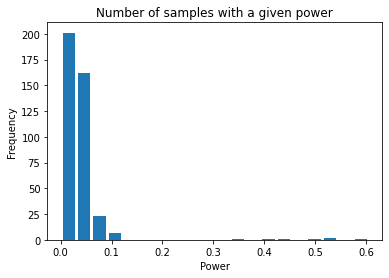

In [ ]:
power = []

for e in X:
    power.append(e[0])

plt.hist(power, bins=20, rwidth=0.8)
plt.title("Number of samples with a given power")
plt.xlabel("Power")
plt.ylabel("Frequency")

Text(0, 0.5, 'Frequency')

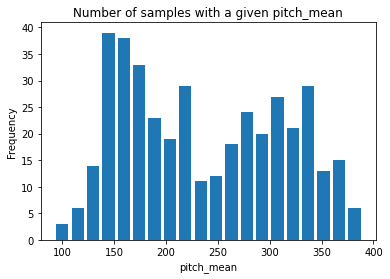

In [ ]:
pitch_mean = []

for e in X:
    pitch_mean.append(e[1])

plt.hist(pitch_mean, bins=20, rwidth=0.8)
plt.title("Number of samples with a given pitch_mean")
plt.xlabel("pitch_mean")
plt.ylabel("Frequency")

Text(0, 0.5, 'Frequency')

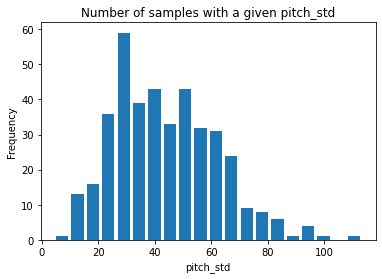

In [ ]:
pitch_std = []

for e in X:
    pitch_std.append(e[2])

plt.hist(pitch_std, bins=20, rwidth=0.8)
plt.title("Number of samples with a given pitch_std")
plt.xlabel("pitch_std")
plt.ylabel("Frequency")

Text(0, 0.5, 'Frequency')

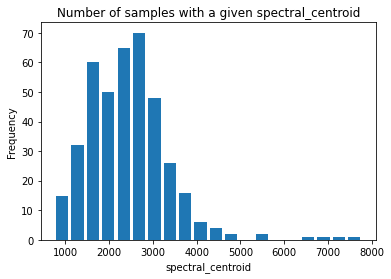

In [ ]:
spectral_centroid = []

for e in X:
    spectral_centroid.append(e[4])

plt.hist(spectral_centroid, bins=20, rwidth=0.8)
plt.title("Number of samples with a given spectral_centroid")
plt.xlabel("spectral_centroid")
plt.ylabel("Frequency")

Text(0, 0.5, 'Frequency')

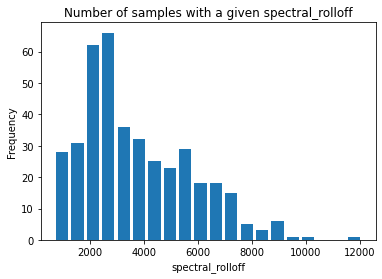

In [ ]:
spectral_rolloff = []

for e in X:
    spectral_rolloff.append(e[5])

plt.hist(spectral_rolloff, bins=20, rwidth=0.8)
plt.title("Number of samples with a given spectral_rolloff")
plt.xlabel("spectral_rolloff")
plt.ylabel("Frequency")

Spectral rolloff, spectral centroid, pitch_std and pitch_mean may provide a lot of valuable information to the model.

# Results

The SVM has an average cross validation score of 0.64, compared to 0.62 of the ExtraTreesClassifier. The training accuracy of both models are very high at 0.93(SVM) and 1.0 (ExtraTreesClassifier). The test accuracy of the SVM is 0.75. Looking at these values, it is clear that the models have overfitted to the training data, as there is over a 0.30 difference between the cross validation scores and the training accuracy. One reason for this is that too many features were selected to train the models with (6). As a result, the model is memorising patterns in the data and therefore is unable to generalise to unseen data. However, another problem is that if a lower number of samples are used, e.g. 2, the model hugely underfits. Therefore, the bigger concern may be that there are not enough samples for each class, which causes this behaviour in the accuracies shown. 

Many techniques were performed such as PCA, to reduce the number of predictors. Using different scaling strategies such as MinMaxScaling was also attempted. However, none of these yielded an increase in performance in the trained models, therefore are excluded in the final implementation. 

In [ ]:
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
import seaborn as sn
import pandas as pd

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, stratify=y)

In [ ]:
inner_cross = KFold(n_splits=3, shuffle=True, random_state=5)

svm_pipe = Pipeline([("scaler", StandardScaler()),
                       ("svm", svm.SVC(decision_function_shape="ovr"))])
params = {
    "svm__C": [1, 5, 10, 50],
    "svm__gamma": [0.1, 0.5, 1]
}

gridSearch = GridSearchCV(estimator=svm_pipe,
                          param_grid=params,
                          cv=inner_cross,
                          refit=True)

outer_cross = KFold(n_splits=10, shuffle=True, random_state=5)
score = cross_val_score(gridSearch, X_train, y_train, cv=outer_cross)
print("Score: ", score.mean())

Score:  0.6375


In [ ]:
gridSearch.fit(X_train, y_train)
print("Training accuracy: ", gridSearch.score(X_train, y_train))
print("Test accuracy: ", gridSearch.score(X_test, y_test))
ypred = gridSearch.predict(X_test)
print(classification_report(y_test, gridSearch.predict(X_test)))

Training accuracy:  0.9375
Test accuracy:  0.75
              precision    recall  f1-score   support

        S111       1.00      1.00      1.00         3
        S119       0.33      0.33      0.33         3
        S128       0.75      1.00      0.86         3
        S152       0.75      1.00      0.86         3
        S157       0.75      1.00      0.86         3
        S166       1.00      1.00      1.00         3
        S169       0.67      0.67      0.67         3
         S17       0.75      1.00      0.86         3
        S201       1.00      0.67      0.80         3
        S205       0.33      0.33      0.33         3
        S216       0.33      0.25      0.29         4
        S219       0.75      1.00      0.86         3
         S23       1.00      0.67      0.80         3
         S38       0.75      1.00      0.86         3
          S4       1.00      0.67      0.80         3
         S41       0.60      1.00      0.75         3
         S49       1.00      1.00

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier

inner_cross = KFold(n_splits=5, shuffle=True, random_state=5)

etc_pipe = Pipeline([("scaler", StandardScaler()),
                       ("etc", ExtraTreesClassifier())])
params = {
    "etc__n_estimators": [50, 100, 150],
}

gridSearch_etc = GridSearchCV(estimator=etc_pipe,
                          param_grid=params,
                          cv=inner_cross,
                          refit=True)

outer_cross = KFold(n_splits=10, shuffle=True, random_state=5)
score = cross_val_score(gridSearch_etc, X_train, y_train, cv=outer_cross)
print("Score: ", score.mean())

Score:  0.615625


In [ ]:
gridSearch_etc.fit(X_train, y_train)
print("Training accuracy: ", gridSearch_etc.score(X_train, y_train))

Training accuracy:  1.0


# Conclusions

In conclusion, to improve the performance of these models, more data is definitely needed. Participants could be asked to add audio files for more songs to the dataset. Different feature extraction methods could be used to reduce the number of features needed, thus bringing down the complexity of the model, and reducing the overfit. Running cross-validation across more folds would also be of benefit, however we should be wary of the computational cost of doing this. As always, different machine learning algorithms could be tested, especially ensemble algorithms in this case, to see if they perform better.